In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime

In [106]:
%matplotlib inline
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams['figure.figsize'] = 16, 12

In [107]:
from scheduler.scheduler import ProbabilisticTaskScheduler, TaskScheduler, Task, Slot, LikelihoodEstimator, UniformDistribution, Time, DiscreteDistribution, BetaDistribution

In [135]:
CATEGORY_PRIORS = dict(wellness=UniformDistribution(Time(hours=14), Time(hours=20)),
              learning=UniformDistribution(Time(hours=10), Time(hours=14)),
              work=UniformDistribution(Time(hours=11), Time(hours=15)),
              personal=UniformDistribution(Time(hours=8), Time(hours=22)),
              fun=UniformDistribution(Time(hours=12), Time(hours=22)),
              chores=UniformDistribution(Time(hours=16), Time(hours=22)))

In [136]:
for cat, dist in CATEGORY_PRIORS.items():
    interval_starts = [s for s in range(0, 24 * 60, 15)]
    freq = dict()
    for s in interval_starts:
        freq[s] = np.mean(BetaDistribution(np.random.randint(1, 100), np.random.randint(1, 50)).sample(1000))
    d = DiscreteDistribution(freq, 15)
    CATEGORY_PRIORS[cat] = d.joint(dist)

In [126]:
class TaskCategoryLikelihoodEstimator(LikelihoodEstimator):

    def likelihood(self, task, priors):
        if not task.category in priors:
            return UniformDistribution(Time(hours=0), Time(hours=24))
        return priors[task.category]

In [127]:
t1 = Task("Workout in the park", "wellness", 60, Time(hours=11))
t2 = Task("Read a book", "learning", 30, Time(hours=10))
scheduler = ProbabilisticTaskScheduler(TaskScheduler([t1, t2], 9, 16), TaskCategoryLikelihoodEstimator(CATEGORY_PRIORS))

In [128]:
task_list = []
for t in scheduler.tasks:
    task_list.append(dict(name=t.name, context=t.category, duration=t.duration))

In [129]:
df = pd.DataFrame.from_dict(task_list)
df.head()

,context,duration,name
0,wellness,60,Workout in the park
1,learning,30,Read a book


In [130]:
dummies = pd.get_dummies(df['context']).rename(columns=lambda x: 'context_' + str(x))
df = pd.concat([df, dummies], axis=1)
df.drop(['context'], inplace=True, axis=1)

In [131]:
df.head()

,duration,name,context_learning,context_wellness
0,60,Workout in the park,0,1
1,30,Read a book,1,0


In [132]:
t3 = Task("Meditate", "wellness", 15)
slots = scheduler.propose_slots(t3)

In [133]:
probs = {s[1].start_minute: s[0] for s in slots}

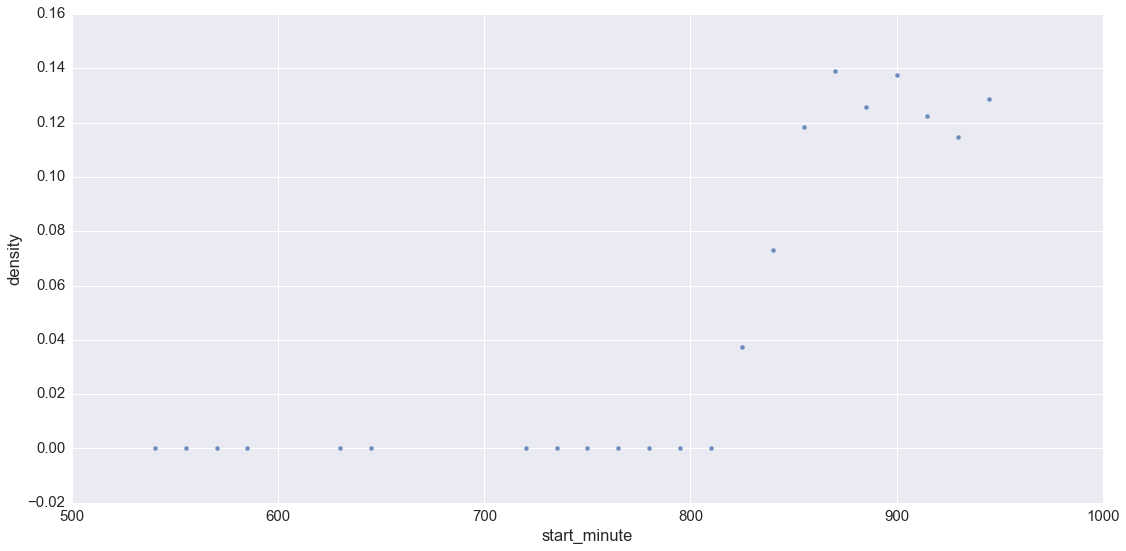

In [134]:
data = pd.DataFrame(list(probs.items()), columns=["start_minute", "density"])
sns.lmplot("start_minute", "density", data, fit_reg=False, size=8, aspect=2)

In [118]:
interval_starts = [s for s in range(0, 24 * 60, 15)]
freq = dict()
for s in interval_starts:
    freq[s] = np.mean(BetaDistribution(np.random.randint(1, 100), np.random.randint(1, 50)).sample(1000))

In [119]:
d = DiscreteDistribution(freq, 15)

<Container object of 96 artists>

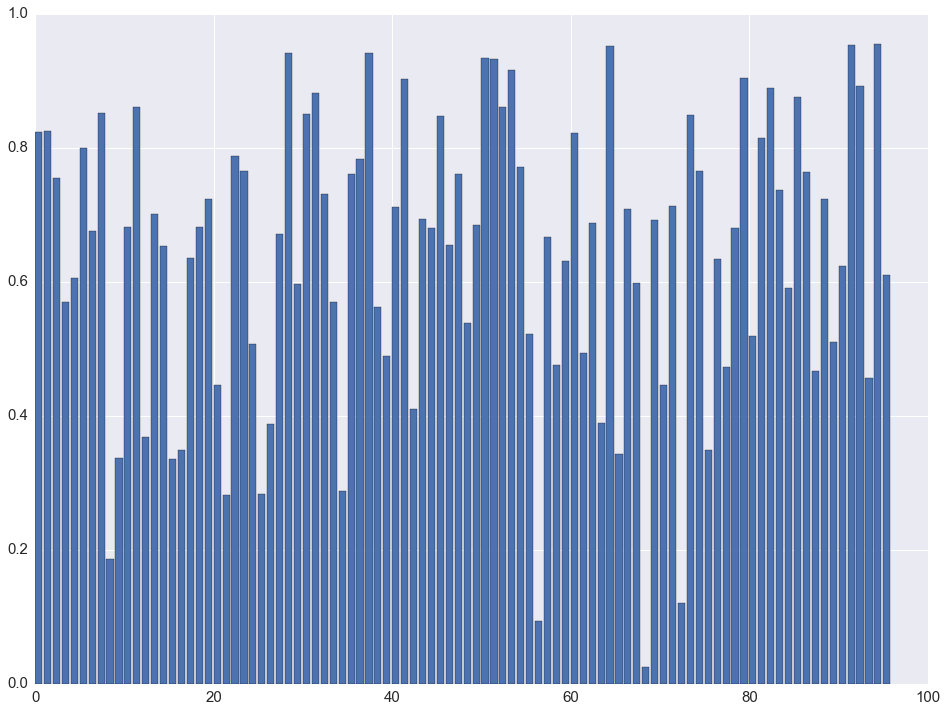

In [120]:
plt.bar(range(len(freq.values())), [v for k, v in sorted(freq.items())])